In [2]:
pip install sumy rouge-score nltk lxml_html_clean spacy matplotlib  


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Imports and global variables

from sumy.parsers.plaintext import PlaintextParser
from sumy.parsers.html import HtmlParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
import spacy
from rouge_score import rouge_scorer
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# python -m spacy download en_core_web_sm <-- Run this command in terminal if the model is not already downloaded
nlp = spacy.load("en_core_web_sm")

# Initialize language for stemmer and the number of most important sentences returned
LANGUAGE = "english"
SENTENCES_COUNT = 3

# **IMPORTANT Note**: Since we are using Sumy package instead of the original PyTLDR, there is no direct counterpart for Relevance sentence scoring. We use the closest equivalent LexRank which also uses cosine similarity.

### Task 1: Three summarization algorithms


In [4]:
# Example text document
example_document = """
Natural language processing and text mining is a course in Master's degree program in the Univeristy of Oulu.
Video games are good for passing time efficiently.
University of Oulu has multiple restaurants which are cheap and offer healthy food.
Multiple different courses require experience on programming languages.
Oulu is known for many technological companies such as Oura and Fingersoft.
"""
parser = PlaintextParser.from_string(example_document, Tokenizer(LANGUAGE))

print("--- Top 3 Most Important Sentences by Each Algorithm ---")
# TextRank summarization
textrank_summarizer = TextRankSummarizer(Stemmer(LANGUAGE))
textrank_summarizer.stop_words = get_stop_words(LANGUAGE)
print("\nTextRank Summary:")
for sentence in textrank_summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

# LSA summarization
lsa_summarizer = LsaSummarizer(Stemmer(LANGUAGE))
lsa_summarizer.stop_words = get_stop_words(LANGUAGE)
print("\nLSA Summary:")
for sentence in lsa_summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

# LexRank summarization
lexrank_summarizer = LexRankSummarizer(Stemmer(LANGUAGE))
lexrank_summarizer.stop_words = get_stop_words(LANGUAGE)
print("\nLexRank Summary:")
for sentence in lexrank_summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

--- Top 3 Most Important Sentences by Each Algorithm ---

TextRank Summary:
Natural language processing and text mining is a course in Master's degree program in the Univeristy of Oulu.
Video games are good for passing time efficiently.
University of Oulu has multiple restaurants which are cheap and offer healthy food.

LSA Summary:
Natural language processing and text mining is a course in Master's degree program in the Univeristy of Oulu.
University of Oulu has multiple restaurants which are cheap and offer healthy food.
Multiple different courses require experience on programming languages.

LexRank Summary:
Natural language processing and text mining is a course in Master's degree program in the Univeristy of Oulu.
Video games are good for passing time efficiently.
University of Oulu has multiple restaurants which are cheap and offer healthy food.


### Task 2: Text summarizer GUI


In [5]:
# The summarizer GUI will open in a new window and this cell will run as long as the window is open.

import tkinter as tk
from tkinter import filedialog, scrolledtext, messagebox


# Helper function for text summarization
def summarize_text(source, is_url=False):
    try:
        if is_url:
            parser = HtmlParser.from_url(source, Tokenizer(LANGUAGE))
        else:
            parser = PlaintextParser.from_file(source, Tokenizer(LANGUAGE))

        # Initialize summarizers, use stemming and stop word removal
        textrank = TextRankSummarizer(Stemmer(LANGUAGE))
        textrank.stop_words = get_stop_words(LANGUAGE)
        lsa = LsaSummarizer(Stemmer(LANGUAGE))
        lsa.stop_words = get_stop_words(LANGUAGE)
        lexrank = LexRankSummarizer(Stemmer(LANGUAGE))
        lexrank.stop_words = get_stop_words(LANGUAGE)

        # Create dictionary for summarizer outputs
        summaries = {
            "TextRank": "\n\n".join(
                str(s) for s in textrank(parser.document, SENTENCES_COUNT)
            ),
            "LSA": "\n\n".join(str(s) for s in lsa(parser.document, SENTENCES_COUNT)),
            "LexRank": "\n\n".join(
                str(s) for s in lexrank(parser.document, SENTENCES_COUNT)
            ),
        }

        return summaries

    except Exception as e:
        messagebox.showwarning("Input Error", "Please enter a URL or choose a file")
        print("Error: ", e)
        return None


# Helper function for browsing a file
def browse_file():
    filename = filedialog.askopenfilename(filetypes=[("Text files", "*.txt")])
    entry_source.delete(0, tk.END)
    entry_source.insert(0, filename)


# Helper function for running summary
def run_summary():
    source = entry_source.get().strip()
    if not source:
        messagebox.showwarning("Input Error", "Please enter a URL or choose a file")
        return None

    is_url = source.startswith("http")
    summaries = summarize_text(source, is_url)

    # Delete old summaries and add new ones (if summarizers are run multiple times)
    if summaries:
        text_textrank.delete(1.0, tk.END)
        text_lsa.delete(1.0, tk.END)
        text_lexrank.delete(1.0, tk.END)
        text_textrank.insert(tk.END, summaries["TextRank"])
        text_lsa.insert(tk.END, summaries["LSA"])
        text_lexrank.insert(tk.END, summaries["LexRank"])


# GUI setup using tkinter library
root = tk.Tk()
root.title("Text Summarizer")
root.geometry("1200x700")

frame_top = tk.Frame(root)
frame_top.pack(pady=10)

tk.Label(
    frame_top, text="Enter URL or choose a file to get 3 most important sentences:"
).pack(anchor="w", padx=5)
entry_source = tk.Entry(frame_top, width=70)
entry_source.pack(side=tk.LEFT, padx=5)

btn_browse = tk.Button(frame_top, text="Browse File", command=browse_file)
btn_browse.pack(side=tk.LEFT, padx=5)

btn_summarize = tk.Button(frame_top, text="Summarize", command=run_summary)
btn_summarize.pack(side=tk.LEFT, padx=5)

# --Text areas for summaries--
frame_texts = tk.Frame(root)
frame_texts.pack(fill=tk.BOTH, expand=True)

# TextRank section
frame_textrank = tk.Frame(frame_texts)
frame_textrank.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=5)

tk.Label(frame_textrank, text="TextRank Summary:").pack(anchor="n", pady=5)
text_textrank = scrolledtext.ScrolledText(frame_textrank, wrap=tk.WORD, width=40)
text_textrank.pack(fill=tk.BOTH, expand=True)

# LSA section
frame_lsa = tk.Frame(frame_texts)
frame_lsa.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=5)

tk.Label(frame_lsa, text="LSA Summary:").pack(pady=5)
text_lsa = scrolledtext.ScrolledText(frame_lsa, wrap=tk.WORD, width=40)
text_lsa.pack(fill=tk.BOTH, expand=True)

# LexRank section
frame_lexrank = tk.Frame(frame_texts)
frame_lexrank.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=5)

tk.Label(frame_lexrank, text="LexRank Summary:").pack(pady=5)
text_lexrank = scrolledtext.ScrolledText(frame_lexrank, wrap=tk.WORD, width=40)
text_lexrank.pack(fill=tk.BOTH, expand=True)

print("Text Summarizer GUI is running on a separate window!")
root.mainloop()

Text Summarizer GUI is running on a separate window!


### Task 3


Total extracted samples: 89
Total extracted words in documents: 61700
rouge2 fmeasure top score for TextRank: 0.187
rouge2 fmeasure top score for LSA: 0.210
rouge2 fmeasure top score for LexRank: 0.182
rouge3 fmeasure top score for TextRank: 0.113
rouge3 fmeasure top score for LSA: 0.137
rouge3 fmeasure top score for LexRank: 0.114


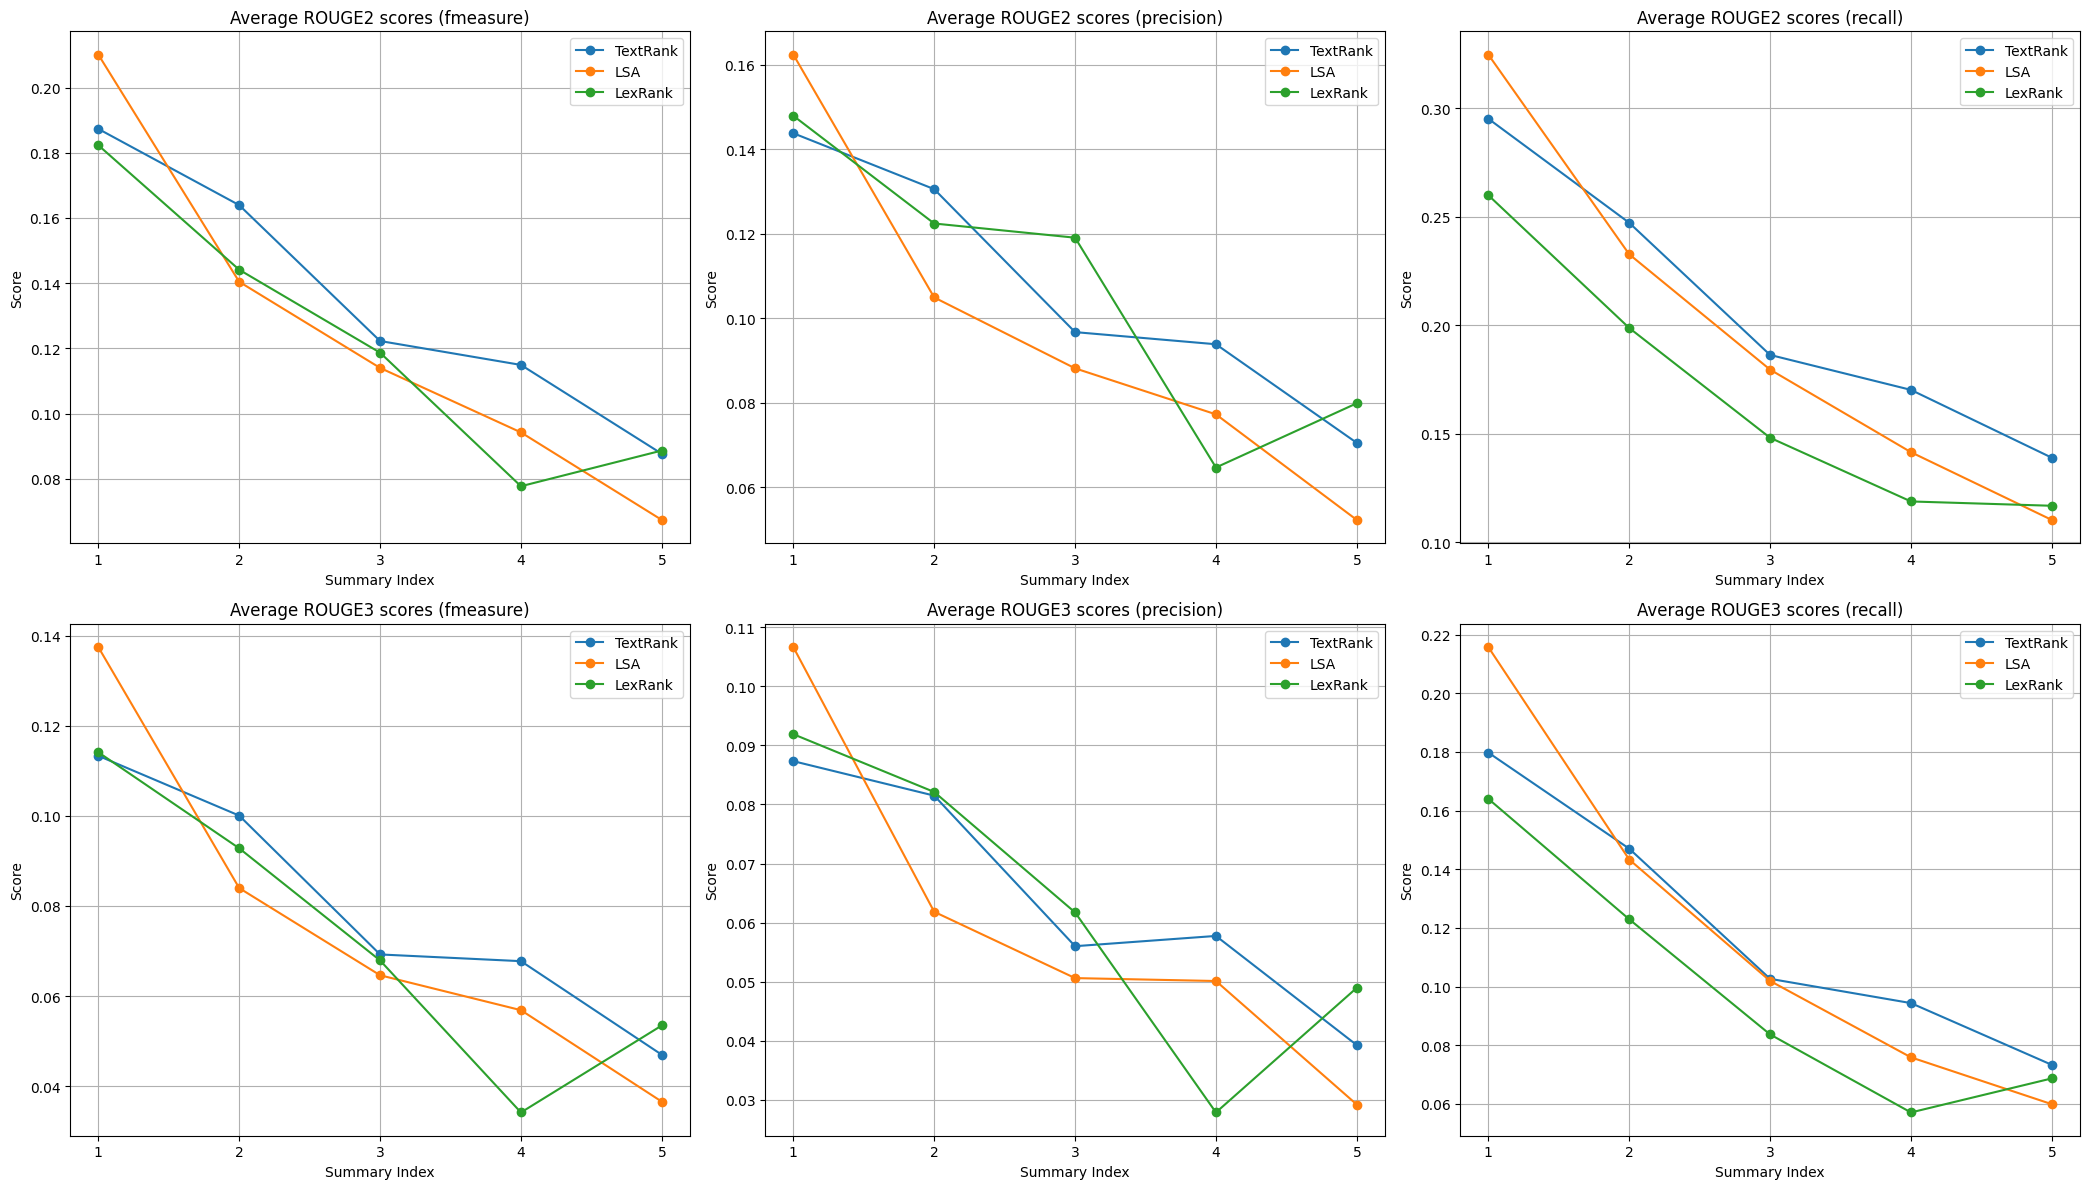

In [43]:
import json

STEM = True
STOP_WORD_REMOVAL = True
TOP_SUMMARIES_COUNT = 5


def extract_doc_and_abstraction(data):
    extracted_data = []
    data_idx = -1
    extracted_word_count = 0
    for idx, line in enumerate(data):
        if line == "Document\n":
            data_idx += 1
            extracted_data.append({"document": data[idx + 1].rstrip("\n")})
            extracted_word_count += len(extracted_data[data_idx]["document"].split())
            continue
        if line.startswith("Facet-"):
            abstraction = line.rstrip("\n").split(" ", 1)[1]
            if "abstractions" not in extracted_data[data_idx]:
                extracted_data[data_idx]["abstractions"] = []
            extracted_data[data_idx]["abstractions"].append(abstraction)

    print(f"Total extracted samples: {len(extracted_data)}")
    print(f"Total extracted words in documents: {extracted_word_count}")
    return extracted_data


def rouge_evaluation(reference, hypothesis, rouge_type):
    scorer = rouge_scorer.RougeScorer([rouge_type], use_stemmer=True)
    score = scorer.score(reference, hypothesis)[rouge_type]
    return score


with open("Data/Cnn&Dailymail/low_abstraction.txt", "r") as f:
    data = extract_doc_and_abstraction(f.readlines())


def get_max_rouge_scores(abstractions, summary, rouge_type):
    scores = [rouge_evaluation(abst, str(summary), rouge_type) for abst in abstractions]
    precision = np.max([score.precision for score in scores])
    recall = np.max([score.recall for score in scores])
    fmeasure = np.max([score.fmeasure for score in scores])
    return precision, recall, fmeasure


if STEM:
    textrank_summarizer = TextRankSummarizer(Stemmer(LANGUAGE))
    lsa_summarizer = LsaSummarizer(Stemmer(LANGUAGE))
    lexrank_summarizer = LexRankSummarizer(Stemmer(LANGUAGE))
else:
    textrank_summarizer = TextRankSummarizer()
    lsa_summarizer = LsaSummarizer()
    lexrank_summarizer = LexRankSummarizer()

if STOP_WORD_REMOVAL:
    textrank_summarizer.stop_words = get_stop_words(LANGUAGE)
    lsa_summarizer.stop_words = get_stop_words(LANGUAGE)
    lexrank_summarizer.stop_words = get_stop_words(LANGUAGE)

summarizers = ["TextRank", "LSA", "LexRank"]
rouge_types = ["rouge2", "rouge3"]
metrics = ["precision", "recall", "fmeasure"]


doc_scores = []
summary_keys = [f"summary{i + 1}" for i in range(TOP_SUMMARIES_COUNT)]
score_template = {
    f"{summary_key}": {
        f"{summarizer}": {
            f"{rouge_type}": {metric: 0 for metric in metrics}
            for rouge_type in rouge_types
        }
        for summarizer in summarizers
    }
    for summary_key in summary_keys
}

for doc in data:
    scores = deepcopy(score_template)
    document = doc["document"]
    abstractions = doc["abstractions"]
    parser = PlaintextParser.from_string(document, Tokenizer(LANGUAGE))

    summaries = {f"{summarizer}": [] for summarizer in summarizers}
    summaries["TextRank"] = textrank_summarizer(parser.document, TOP_SUMMARIES_COUNT)
    summaries["LSA"] = lsa_summarizer(parser.document, TOP_SUMMARIES_COUNT)
    summaries["LexRank"] = lexrank_summarizer(parser.document, TOP_SUMMARIES_COUNT)

    for summary_idx in range(TOP_SUMMARIES_COUNT):
        for summarizer in summarizers:
            for rouge_type in rouge_types:
                summary_key = f"summary{summary_idx + 1}"
                precision, recall, fmeasure = get_max_rouge_scores(
                    abstractions, summaries[summarizer][summary_idx], rouge_type
                )
                scores[summary_key][summarizer][rouge_type]["precision"] = precision
                scores[summary_key][summarizer][rouge_type]["recall"] = recall
                scores[summary_key][summarizer][rouge_type]["fmeasure"] = fmeasure
                if fmeasure > 1.0:  # Set threshold to smaller value to see outputs
                    print(
                        f"{rouge_type} {summarizer} {summary_key} fmeasure: {fmeasure:.3f}\n"
                        f"Abstractions: {json.dumps(abstractions, indent=2)}\n"
                        f"Summary: {json.dumps(str(summaries[summarizer][summary_idx]), indent=2)}"
                    )

    doc_scores.append(scores)


avg_scores = deepcopy(score_template)

for doc_score in doc_scores:
    for summary_key in summary_keys:
        for summarizer in summarizers:
            for rouge_type in rouge_types:
                avg_scores[summary_key][summarizer][rouge_type]["precision"] += (
                    doc_score[summary_key][summarizer][rouge_type]["precision"]
                    / len(doc_scores)
                )
                avg_scores[summary_key][summarizer][rouge_type]["recall"] += doc_score[
                    summary_key
                ][summarizer][rouge_type]["recall"] / len(doc_scores)
                avg_scores[summary_key][summarizer][rouge_type]["fmeasure"] += (
                    doc_score[summary_key][summarizer][rouge_type]["fmeasure"]
                    / len(doc_scores)
                )


def plot_rouge_scores(ax, rouge_type, metric):
    summary_indices = range(1, TOP_SUMMARIES_COUNT + 1)
    ax.set_title(f"Average {rouge_type.upper()} scores ({metric})")
    ax.set_xlabel("Summary Index")
    ax.set_ylabel("Score")
    ax.set_xticks(summary_indices)
    for summarizer in summarizers:
        scores = [
            avg_scores[f"summary{idx}"][summarizer][rouge_type][metric]
            for idx in summary_indices
        ]
        ax.plot(summary_indices, scores, marker="o", label=summarizer)
        if metric == "fmeasure":
            print(f"{rouge_type} fmeasure top score for {summarizer}: {scores[0]:.3f}")
    ax.legend()
    ax.grid()


# Plot the average ROUGE scores
_, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(21, 12))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
for i, (rouge_type, metric) in enumerate(
    [
        ("rouge2", "fmeasure"),
        ("rouge2", "precision"),
        ("rouge2", "recall"),
        ("rouge3", "fmeasure"),
        ("rouge3", "precision"),
        ("rouge3", "recall"),
    ]
):
    plot_rouge_scores(axes[i], rouge_type, metric)

plt.tight_layout()
plt.show()

### Task 4

We want to extend the above summarization by incorporating coherence of text with respect to  
named-entity. For this purpose, first use SpaCy named-entity tagger and identify person or  
organization named-entity. Suggest a simple heuristic that enables whenever a sentence outputted by  
a given algorithm contains a person or an organization named-entity, then other sentences in the  
original document that contain the same named-entity, if not outputted by the underlined algorithm,  
will also be included in the summarizer up to a certain threshold (that you can discuss and tune up).  
Run the newly designed algorithm on the same CNN/Dailymail dataset, and report the ROUGE-2 and  
ROUGE-3 performances


Total extracted samples: 89
TextRank - rouge2 - Precision: 0.0975, Recall: 0.3157, F-measure: 0.1400
TextRank - rouge3 - Precision: 0.0598, Recall: 0.1947, F-measure: 0.0848
LSA - rouge2 - Precision: 0.0933, Recall: 0.2649, F-measure: 0.1284
LSA - rouge3 - Precision: 0.0635, Recall: 0.1730, F-measure: 0.0849
LexRank - rouge2 - Precision: 0.1032, Recall: 0.2220, F-measure: 0.1256
LexRank - rouge3 - Precision: 0.0579, Recall: 0.1249, F-measure: 0.0699


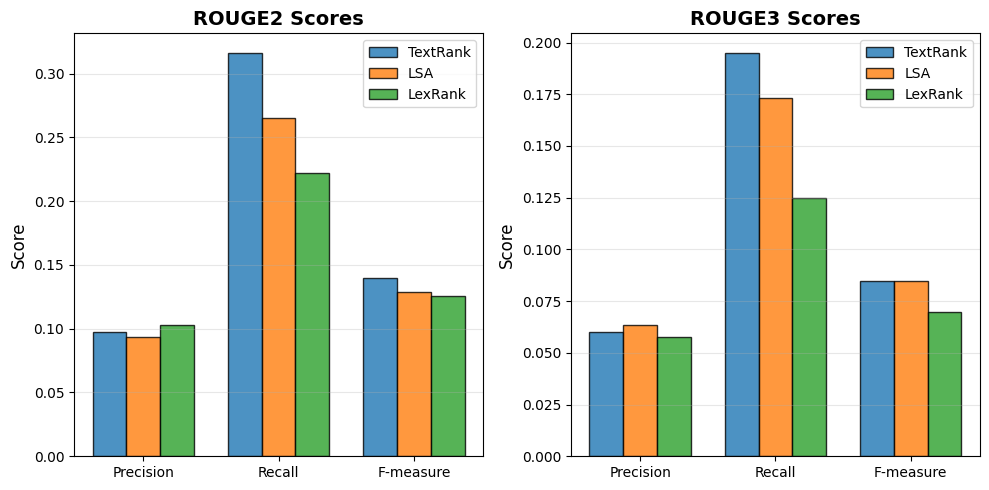

In [10]:
MAX_NEW_SENTENCES = 2


def extract_doc_and_abstraction(data):
    extracted_data = []
    data_idx = -1
    for idx, line in enumerate(data):
        if line == "Document\n":
            data_idx += 1
            extracted_data.append({"document": data[idx + 1].rstrip("\n")})
            continue
        if line.startswith("Facet-"):
            abstraction = line.rstrip("\n").split(" ", 1)[1]
            if "abstractions" not in extracted_data[data_idx]:
                extracted_data[data_idx]["abstractions"] = []
            extracted_data[data_idx]["abstractions"].append(abstraction)
    print(f"Total extracted samples: {len(extracted_data)}")
    return extracted_data


with open("Data/Cnn&Dailymail/low_abstraction.txt", "r") as f:
    data = extract_doc_and_abstraction(f.readlines())


def rouge_evaluation(reference, hypothesis, rouge_type):
    scorer = rouge_scorer.RougeScorer([rouge_type], use_stemmer=True)
    score = scorer.score(reference, hypothesis)[rouge_type]
    return score


def get_max_rouge_scores(abstractions, summary, rouge_type):
    scores = [rouge_evaluation(abst, str(summary), rouge_type) for abst in abstractions]
    precision = np.max([score.precision for score in scores])
    recall = np.max([score.recall for score in scores])
    fmeasure = np.max([score.fmeasure for score in scores])
    return precision, recall, fmeasure


def add_sents_containing_named_entities(summary, document, max_new_sentences):
    if max_new_sentences == 0:
        return str(summary)

    summary_doc = nlp(str(summary))
    summary_entities = {
        ent.text for ent in summary_doc.ents if ent.label_ in ("PERSON", "ORG")
    }

    if not summary_entities:
        return str(summary)

    document_sents = Tokenizer(LANGUAGE).to_sentences(document)

    summary_text = str(summary)
    candidates = []

    for sent in document_sents:
        # Skip if it's the summary sentence itself
        if sent == summary_text:
            continue

        sent_doc = nlp(sent)
        sent_entities = {
            ent.text for ent in sent_doc.ents if ent.label_ in ("PERSON", "ORG")
        }

        overlap = summary_entities & sent_entities

        if overlap:
            candidates.append((sent, len(overlap)))

    # Sort by number of matching entities (descending)
    candidates.sort(key=lambda x: x[1], reverse=True)
    if candidates and candidates[0][1] > 2:  # Change threshold to see more/less outputs
        print("Good candidate found:", candidates[0])
        print("Summary text:", summary_text)
        print("Named entities in summary:", summary_entities)

    # Take top max_new_sentences
    selected_sentences = [summary_text]
    selected_sentences.extend(sent for sent, _ in candidates[:max_new_sentences])

    enhanced_summary = " ".join(selected_sentences)

    return enhanced_summary


textrank_summarizer = TextRankSummarizer(Stemmer(LANGUAGE))
textrank_summarizer.stop_words = get_stop_words(LANGUAGE)
lsa_summarizer = LsaSummarizer(Stemmer(LANGUAGE))
lsa_summarizer.stop_words = get_stop_words(LANGUAGE)
lexrank_summarizer = LexRankSummarizer(Stemmer(LANGUAGE))
lexrank_summarizer.stop_words = get_stop_words(LANGUAGE)

summarizers = ["TextRank", "LSA", "LexRank"]
rouge_types = ["rouge2", "rouge3"]
metrics = ["precision", "recall", "fmeasure"]

TOP_SUMMARIES_COUNT = 1

doc_scores = []
score_template = {
    f"{summarizer}": {
        f"{rouge_type}": {metric: 0 for metric in metrics} for rouge_type in rouge_types
    }
    for summarizer in summarizers
}

for doc in data:
    scores = deepcopy(score_template)
    document = doc["document"]
    abstractions = doc["abstractions"]
    parser = PlaintextParser.from_string(document, Tokenizer(LANGUAGE))

    summaries = {f"{summarizer}": [] for summarizer in summarizers}
    summaries["TextRank"] = textrank_summarizer(parser.document, TOP_SUMMARIES_COUNT)[0]
    summaries["LSA"] = lsa_summarizer(parser.document, TOP_SUMMARIES_COUNT)[0]
    summaries["LexRank"] = lexrank_summarizer(parser.document, TOP_SUMMARIES_COUNT)[0]

    summaries["TextRank"] = add_sents_containing_named_entities(
        summaries["TextRank"], document, MAX_NEW_SENTENCES
    )
    summaries["LSA"] = add_sents_containing_named_entities(
        summaries["LSA"], document, MAX_NEW_SENTENCES
    )
    summaries["LexRank"] = add_sents_containing_named_entities(
        summaries["LexRank"], document, MAX_NEW_SENTENCES
    )

    for summarizer in summarizers:
        for rouge_type in rouge_types:
            precision, recall, fmeasure = get_max_rouge_scores(
                abstractions, summaries[summarizer], rouge_type
            )
            scores[summarizer][rouge_type]["precision"] = precision
            scores[summarizer][rouge_type]["recall"] = recall
            scores[summarizer][rouge_type]["fmeasure"] = fmeasure

    doc_scores.append(scores)


avg_scores = deepcopy(score_template)

for doc_score in doc_scores:
    for summarizer in summarizers:
        for rouge_type in rouge_types:
            avg_scores[summarizer][rouge_type]["precision"] += doc_score[summarizer][
                rouge_type
            ]["precision"] / len(doc_scores)
            avg_scores[summarizer][rouge_type]["recall"] += doc_score[summarizer][
                rouge_type
            ]["recall"] / len(doc_scores)
            avg_scores[summarizer][rouge_type]["fmeasure"] += doc_score[summarizer][
                rouge_type
            ]["fmeasure"] / len(doc_scores)


for summarizer in summarizers:
    for rouge_type in rouge_types:
        print(
            f"{summarizer} - {rouge_type} - Precision: {avg_scores[summarizer][rouge_type]['precision']:.4f}, "
            f"Recall: {avg_scores[summarizer][rouge_type]['recall']:.4f}, "
            f"F-measure: {avg_scores[summarizer][rouge_type]['fmeasure']:.4f}"
        )


def plot_rouge_scores(ax, rouge_type):
    metrics_labels = ["Precision", "Recall", "F-measure"]
    x_positions = np.arange(len(metrics_labels))
    bar_width = 0.25

    ax.set_title(f"{rouge_type.upper()} Scores", fontsize=14, fontweight="bold")
    ax.set_ylabel("Score", fontsize=12)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(metrics_labels)

    colors = {"TextRank": "#1f77b4", "LSA": "#ff7f0e", "LexRank": "#2ca02c"}

    for i, summarizer in enumerate(summarizers):
        scores = [avg_scores[summarizer][rouge_type][metric] for metric in metrics]
        offset = (i - 1) * bar_width
        ax.bar(
            x_positions + offset,
            scores,
            bar_width,
            label=summarizer,
            color=colors[summarizer],
            alpha=0.8,
            edgecolor="black",
        )

    ax.legend(loc="upper right", fontsize=10)
    ax.grid(axis="y", alpha=0.3)


# Plot the average ROUGE scores
_, axes = plt.subplots(1, 2, figsize=(10, 5))
for j, rouge_type in enumerate(rouge_types):
    plot_rouge_scores(axes[j], rouge_type)

plt.tight_layout()
plt.show()


### Task 5


In [ ]:
import ollama

MODEL_NAME = "llama3.1"
DOC_LIMIT = 1


def extract_doc_and_abstraction(data, doc_limit=None):
    extracted_data = []
    for idx, line in enumerate(data):
        if len(extracted_data) == doc_limit:
            break
        if line == "Document\n":
            extracted_data.append({"document": data[idx + 1].rstrip("\n")})

    return extracted_data


with open("Data/Cnn&Dailymail/low_abstraction.txt", "r") as f:
    data = extract_doc_and_abstraction(f.readlines(), DOC_LIMIT)

example_document = data[0]["document"] if data else ""

print("Example Document:\n", example_document)

prompt = (
    "Generate 10 different summaries of length about 20 words for the following document:\n\n"
    + example_document
)
response = ollama.generate(MODEL_NAME, prompt)
print(response.text)
# TODO


Example Document:
 marseille , france -lrb- cnn -rrb- the french prosecutor leading an investigation into the crash of germanwings flight 9525 insisted wednesday that he was not aware of any video footage from on board the plane . marseille prosecutor brice robin told cnn that `` so far no videos were used in the crash investigation . '' he added , `` a person who has such a video needs to immediately give it to the investigators . '' robin 's comments follow claims by two magazines , german daily bild and french paris match , of a cell phone video showing the harrowing final seconds from on board germanwings flight 9525 as it crashed into the french alps . all 150 on board were killed . paris match and bild reported that the video was recovered from a phone at the wreckage site . the two publications described the supposed video , but did not post it on their websites . the publications said that they watched the video , which was found by a source close to the investigation . `` one 

KeyboardInterrupt: 

### Task 6: Algorithm performance on Opinosis dataset


In [9]:
import os
from rouge_score import rouge_scorer
from glob import glob


# Helper function for text summarization
def summarize_text(text, summarizer):
    parser = PlaintextParser.from_string(text, Tokenizer(LANGUAGE))
    return " ".join(str(s) for s in summarizer(parser.document, SENTENCES_COUNT))


# Helper function for ROUGE evaluation
def evaluate_rouge(system_summary, reference_summary):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2"], use_stemmer=True)
    scores = scorer.score(reference_summary, system_summary)
    return {k: v.fmeasure for k, v in scores.items()}


# Setup summarizers (use stemming and stopword removal)
summarizers = {
    "TextRank": TextRankSummarizer(Stemmer(LANGUAGE)),
    "LSA": LsaSummarizer(Stemmer(LANGUAGE)),
    "LexRank": LexRankSummarizer(Stemmer(LANGUAGE)),
}
for s in summarizers.values():
    s.stop_words = get_stop_words(LANGUAGE)

# Loop through the opinosis dataset
topics_path = "Data/OpinosisDataset/topics"
summaries_path = "Data/OpinosisDataset/summaries-gold"

result_list = {name: [] for name in summarizers}

for topic_file in os.listdir(topics_path):
    if not topic_file.endswith(".txt.data"):
        continue

    # Get the topic name from the file and construct paths for topics and gold summaries
    topic_name = topic_file.replace("txt.data", "")
    topic_path = os.path.join(topics_path, topic_file)
    summaries_dir = os.path.join(summaries_path, topic_name)

    if not os.path.exists(summaries_dir):
        continue

    # Read all reviews for the topic (there are mixed encodings in the dataset)
    try:
        with open(topic_path, "r", encoding="utf-8") as file:
            text = file.read()
    except UnicodeDecodeError:
        with open(topic_path, "r", encoding="latin-1") as file:
            text = file.read()

    # Read all gold summaries for the topic with glob
    summaries_paths = sorted(glob(os.path.join(summaries_dir, "*.gold")))
    gold_summaries = []
    for s in summaries_paths:
        with open(s, "r", encoding="utf-8") as summary_file:
            gold_summaries.append(summary_file.read())

    # Evaluate each summarizer
    for name, summarizer in summarizers.items():
        system_summary = summarize_text(text, summarizer)
        all_rouge = []
        for gold in gold_summaries:
            all_rouge.append(evaluate_rouge(system_summary, gold))

        # Compute average across all gold summaries
        avg_rouge1 = sum(r["rouge1"] for r in all_rouge) / len(all_rouge)
        avg_rouge2 = sum(r["rouge2"] for r in all_rouge) / len(all_rouge)
        result_list[name].append({"rouge1": avg_rouge1, "rouge2": avg_rouge2})

# Compute overall averages
print(
    "--- Performance of TextRank, Latent Semantic and LexRank algorithms on Opinosis dataset in terms of Rouge-1 and Rouge-2 ---"
)
for name, textrank_scores in result_list.items():
    avg_r1 = sum(s["rouge1"] for s in textrank_scores) / len(textrank_scores)
    avg_r2 = sum(s["rouge2"] for s in textrank_scores) / len(textrank_scores)
    print(f"\n{name} - ROUGE-1: {avg_r1:.3f} | ROUGE-2: {avg_r2:.3f}")

--- Performance of TextRank, Latent Semantic and LexRank algorithms on Opinosis dataset in terms of Rouge-1 and Rouge-2 ---


ZeroDivisionError: division by zero

### Task 7


In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.edmundson import EdmundsonSummarizer
from sumy.nlp.stemmers import Stemmer


def edmundson_summarize():
    # Initialize Edmundson summarizer
    # Has default weights: cue = 1, key = 0, title = 1, location = 1
    summarizer = EdmundsonSummarizer(Stemmer(LANGUAGE))
    summarizer.stop_words = get_stop_words(LANGUAGE)

    # Set null words (irrelevant words)
    summarizer.null_words = get_stop_words(LANGUAGE)

    # Set custom bonus and stigma words
    # For bonus words, include positively relevant words in reviews
    summarizer.bonus_words = {
        "best",
        "excellent",
        "great",
        "good",
        "nice",
        "perfect",
        "better",
        "awesome",
        "recommend",
        "super",
        "fantastic",
        "exceptional",
        "outstanding",
    }
    # For stigma words, include negatively relevant words in reviews
    summarizer.stigma_words = {
        "bad",
        "worst",
        "terrible",
        "poor",
        "horrible",
        "disappointing",
        "avoid",
        "unfortunately",
        "cannot",
        "useless",
        "problem",
        "issue",
        "awful",
    }

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2"], use_stemmer=True)
    results = []
    # Process each topic file
    for topic_file in os.listdir(topics_path):
        if not topic_file.endswith(".txt.data"):
            continue
        topic_name = topic_file.replace(".txt.data", "")
        topic_path = os.path.join(topics_path, topic_file)
        summaries_dir = os.path.join(summaries_path, topic_name)
        if not os.path.exists(summaries_dir):
            continue
        # Read all reviews
        try:
            with open(topic_path, "r", encoding="utf-8") as file:
                text = file.read()
        except UnicodeDecodeError:
            with open(topic_path, "r", encoding="latin-1") as file:
                text = file.read()
        # Generate summary
        parser = PlaintextParser.from_string(text, Tokenizer(LANGUAGE))
        summary = " ".join(
            str(sentence) for sentence in summarizer(parser.document, SENTENCES_COUNT)
        )
        # Read and evaluate against gold summaries
        summaries_paths = sorted(glob(os.path.join(summaries_dir, "*.gold")))
        scores_for_topic = []
        for gold_path in summaries_paths:
            with open(gold_path, "r", encoding="utf-8") as f:
                gold_summary = f.read()
                scores = scorer.score(gold_summary, summary)
                scores_for_topic.append(
                    {
                        "rouge1": scores["rouge1"].fmeasure,
                        "rouge2": scores["rouge2"].fmeasure,
                    }
                )
        # Compute average scores
        if scores_for_topic:
            avg_rouge1 = sum(score["rouge1"] for score in scores_for_topic) / len(
                scores_for_topic
            )
            avg_rouge2 = sum(score["rouge2"] for score in scores_for_topic) / len(
                scores_for_topic
            )
            results.append({"rouge1": avg_rouge1, "rouge2": avg_rouge2})
    # Compute and output results
    if results:
        final_rouge1 = sum(result["rouge1"] for result in results) / len(results)
        final_rouge2 = sum(result["rouge2"] for result in results) / len(results)
        print("\nSumy Edmundson summarizer ROUGE-1, ROUGE-2 scores:")
        print(f"ROUGE-1: {final_rouge1:.3f}")
        print(f"ROUGE-2: {final_rouge2:.3f}")
    else:
        print("No results generated")


print("Test the summarizer on Opinosis dataset:")
edmundson_summarize()

### Task 8


In [ ]:
# Code here

### Task 10


In [ ]:
# Code here